# Contexte

Ce projet rentre dans la formation "Artificial Intelligence for robotics with Python" proposée par Micro Club. A travers ce court projet vous aurez à revoir les principes de classification utilisant des méthodes de Machine Learning classique comme vus durant la séance 3. 

Ce projet se base sur ce [dataset](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) donnant les données CTG (cardiotocogramme) pour définir les taux de risques de maladie de foetus, donc l'objectif est de classer les différents cas en trois catégories : 
- Normal : 1
- Suspect : 2
- Malade : 3

Ainsi ce genre de projet vous permettra de vous entraîner sur de vrais problématiques. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Pré-traitement des données
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Pour tester les performances des modèles utilisés
from sklearn import metrics

# Classification
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Resampling 
from sklearn.utils import resample


# Charger les données

In [40]:
fetal_data = pd.read_csv("fetal_health.csv")
fetal_data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


## Subdiviser les données

On ne va analyser que les données d'entrainement pour éviter tout biais avec les données qu'on va utiliser pour tester notre modèle

In [41]:
fetal_features = fetal_data.copy()
labels = fetal_features.fetal_health
fetal_features.drop(columns="fetal_health", axis=1, inplace=True)

labels -= 1 # originally, the targets are 1-3; we will use 0-2

fetal_train, fetal_test, labels_train, labels_test = train_test_split(fetal_features, labels, test_size=0.3, random_state=42, stratify=labels)

fetal_train.shape, fetal_test.shape

((1488, 21), (638, 21))

## Analyse des données

Dans cette partie on va avoir une vue d'ensemble de nos données
- On tire le type des données
- La distribution des différentes classes
- Valeurs manquantes ou pas ? 
- Distribution des différentes variables

In [42]:
fetal_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488 entries, 480 to 229
Data columns (total 21 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          1488 non-null   float64
 1   accelerations                                           1488 non-null   float64
 2   fetal_movement                                          1488 non-null   float64
 3   uterine_contractions                                    1488 non-null   float64
 4   light_decelerations                                     1488 non-null   float64
 5   severe_decelerations                                    1488 non-null   float64
 6   prolongued_decelerations                                1488 non-null   float64
 7   abnormal_short_term_variability                         1488 non-null   float64
 8   mean_value_of_short_term_variability 

On peut déjà voir qu'on a 22 colonnes dans notre tableau : 
- 21 caractéristiques 
- fetal_health qui constitue la classe cible de notre problème

On peut aussi voir que toutes les colonnes sont réelles et il n'y aucune valeur manquante ca nous évitera donc de faire un travail de remplacement de ces valeurs. On va voir maintenant la corrélation entre les différentes variables

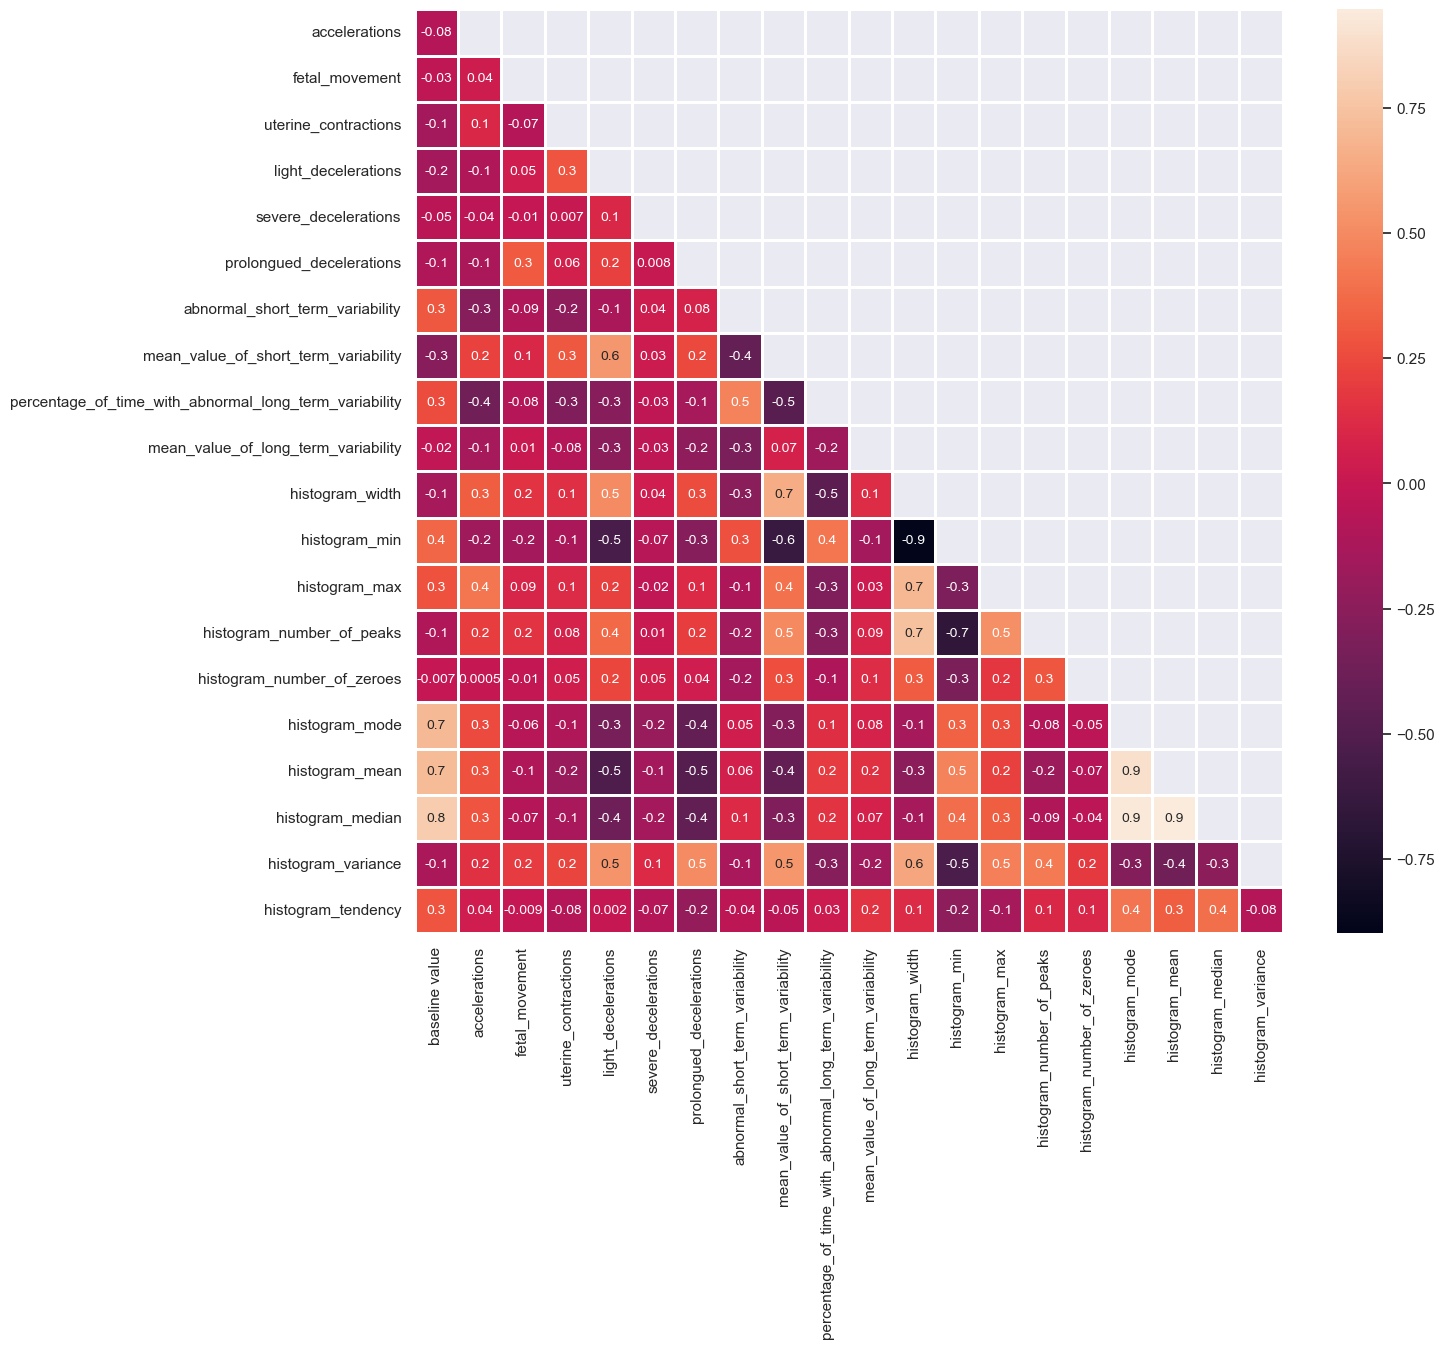

In [43]:
plt.figure(figsize=(14,12))
mask = np.triu(np.ones_like(fetal_train.corr(), dtype=bool))
sns.heatmap(fetal_train.corr().iloc[1:,:-1], mask=mask[1:,:-1], annot=True, fmt=".1g", linewidths=2.0, annot_kws={"size": 10})
plt.show()

On peut voir certaines variables fortement corrélée ce qui nous indique que par la suite on va éventuellement supprimer quelques unes de ces colonnes pour chercher un meilleur résultat. Ce sera considéré dans un second temps.

On observe maintenant la corrélation qui existe entre chaque feature et la classe cible qu'on a 

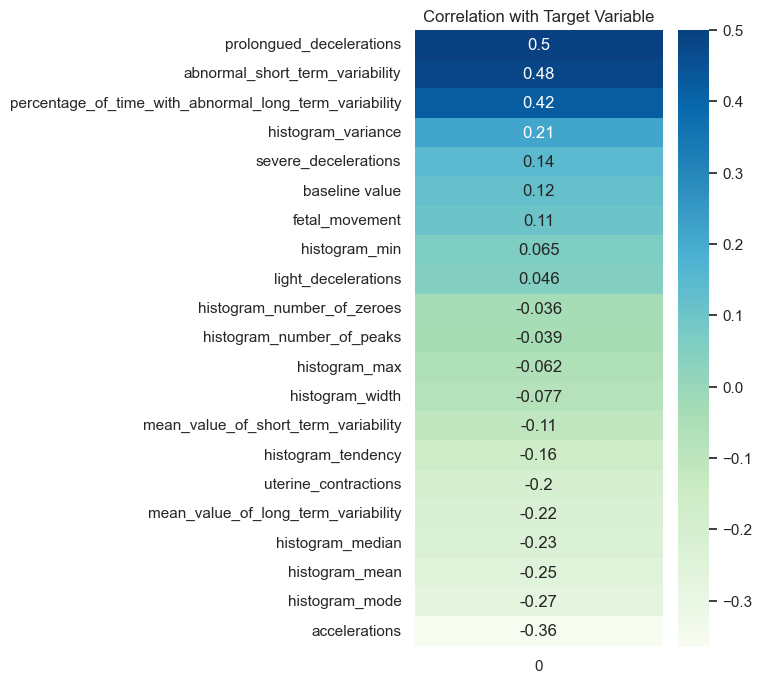

In [44]:
# Create a correlation matrix with target variable
corr_with_target = fetal_train.corrwith(labels_train)

# Sort features by correlation with target variable
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

On peut ainsi voir que certaines features ont quasi aucune corrélation avec la classe de sortie (corrélation proche de 0) donc probablement seront inutile dans notre problème, à voir plus tard

In [45]:
labels_train.value_counts() / len(labels_train) * 100

0.0    77.822581
1.0    13.911290
2.0     8.266129
Name: fetal_health, dtype: float64

- On peut voir qu'ici on a un problème de classification assez déséquilibré et par conséquent on pourra voir que la classe 1 sera relativement simple à classifier par rapport aux deux autres classes
- Aussi pour l'évaluation du modèle on n'utilisera pas l'accuracy car ne permettant pas de rendre compte fidèlement de la qualité du modèle dans une telle situation (classe déséquilibrée)
- On va effectuer l'évaluation du modèle par rapport au F1-Score et le AUC-Score

On va maintenant observer les distributions des différentes variables

C:\Users\dell\AppData\Local\Temp\ipykernel_22636\89395697.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


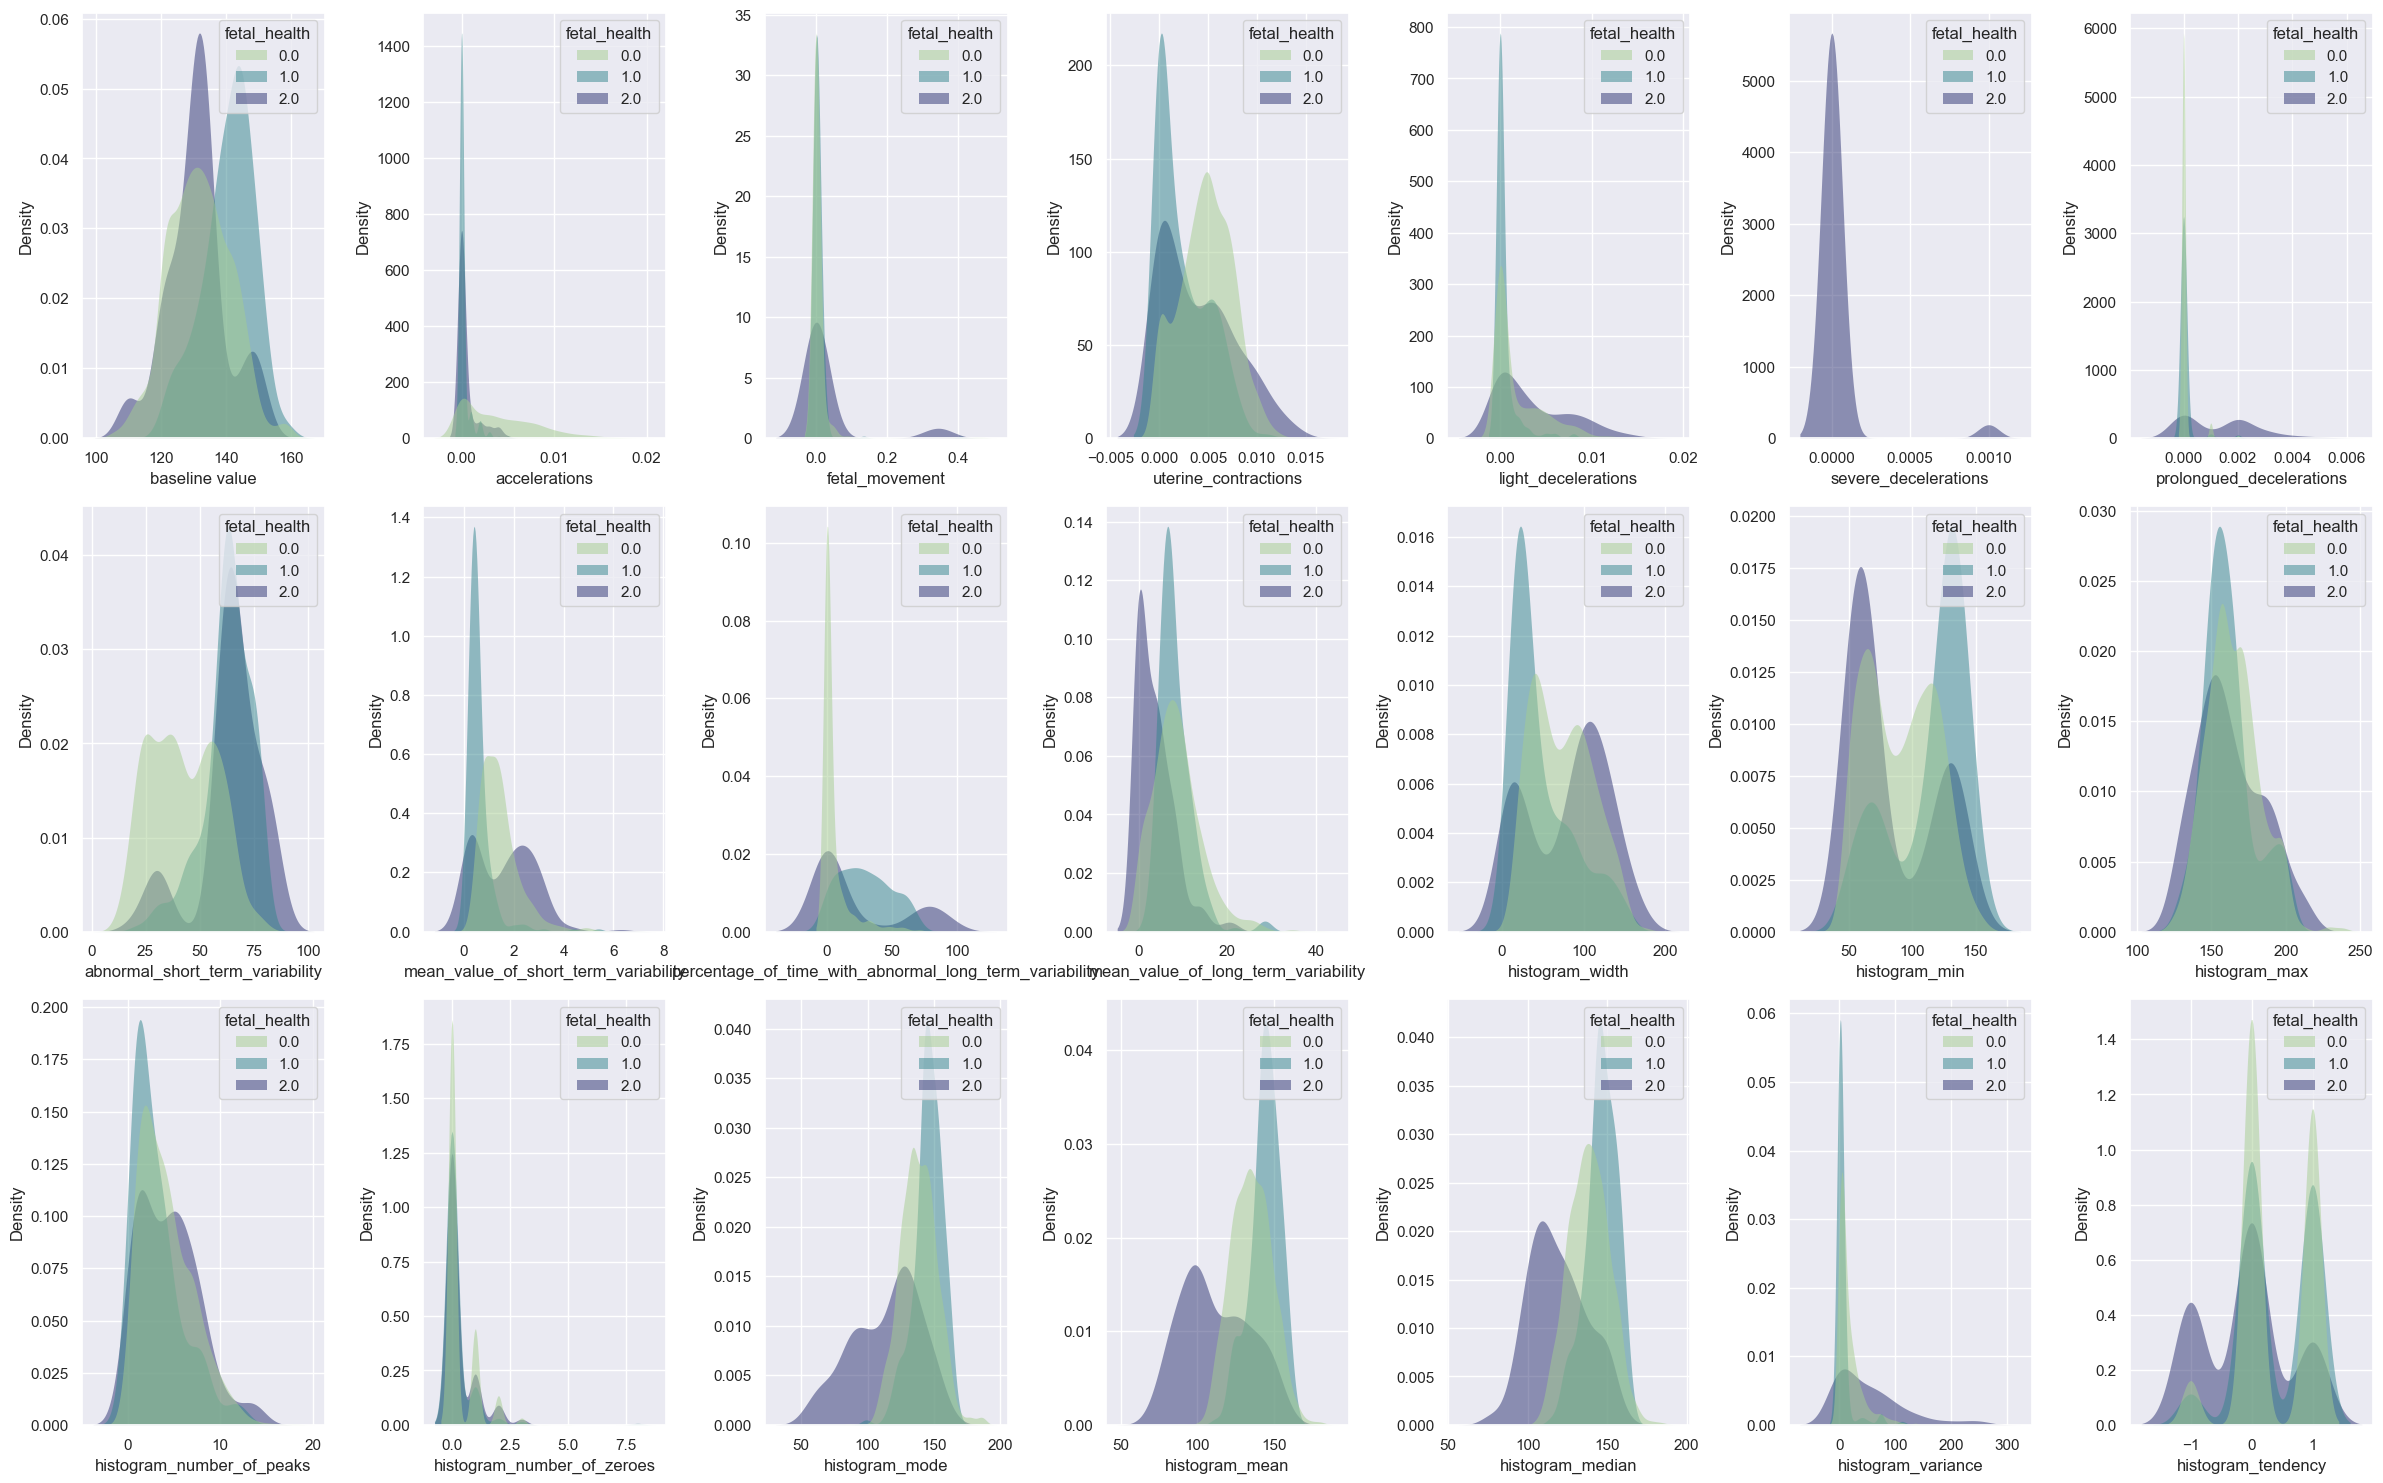

In [46]:
features = fetal_train.columns
all_data_train = fetal_train.copy()
all_data_train["fetal_health"] = labels_train
plt.figure(figsize=(24, 15))
i = 1
for feature in features : 
   plt.subplot(3, 7, i)
   sns.kdeplot(
      data=all_data_train, x=feature, hue="fetal_health",
      fill=True, common_norm=False, palette="crest",
      alpha=.5, linewidth=0
   )
   i += 1
plt.tight_layout()

Se basant sur ces distributions on peut déjà voir que la classification sera relativement complexe puisque les distributions entre les trois classes sont relativement similaire dans une bonne partie des caractéristiques de notre problème

## Préparation des données

In [47]:
fetal_data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


On peut voir ici que les caractéristiques ne sont pas normalisées et donc un travail de normalisation doit être fait, pour se faire on va utiliser StandarScaler de Scikitlearn. Pour éviter tout Data Leakage on va subdiviser notre jeux de données en jeux d'entrainement et un autre de test et normaliser chacun indépendemment

In [48]:
scaler = StandardScaler()

fetal_train = pd.DataFrame(scaler.fit_transform(fetal_train), columns=features)
fetal_test = pd.DataFrame(scaler.transform(fetal_test), columns=features)

On modifie l'ensemble de test en fonction de la moyenne et de l'écart type de l'ensemble d'entrainement pour éviter tout data leakage

## Classification

On va commencer par tirer des performances initiales en classant directement sans aucune sélection des paramètres. Dans un premier temps je vais sélectionner 4 modèles scikit learn : 
- KNN
- SVM
- Random Forest
- Naive Bayes

Représentant 4 approches différentes pour avoir des performances variées :

### Entrainement des modèles

In [109]:
# la mesure de distance est mise par défaut et c'est donc une distance Euclidienne
knn_parameters = {'n_neighbors':np.arange(1,20,2), 'p' : np.arange(1,4,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(fetal_train,labels_train)

Les meilleurs paramètres sont : {'n_neighbors': 3, 'p': 1}


KNeighborsClassifier(n_neighbors=3, p=1)

In [114]:
svm_parameters = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ["poly", "rbf", "sigmoid"], 'degree' : np.arange(2, 10), 'gamma' : ['scale', 'auto'], 'decision_function_shape' : ['ovo', 'ovr']}
svm = SVC()
clf = GridSearchCV(svm, svm_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

svm=SVC(**clf.best_params_, probability=True) # pour pouvoir calculer le ROC AUC Score
svm.fit(fetal_train,labels_train)

Les meilleurs paramètres sont : {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=10, decision_function_shape='ovo', degree=2)

In [111]:
forest_parameters = {'n_estimators' : np.arange(50, 251, 10), 'criterion' : ['gini', 'entropy', 'log_loss'], 'max_features' : ['sqrt', 'log2']}
forest = RandomForestClassifier()
clf = GridSearchCV(forest, forest_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

forest=RandomForestClassifier(**clf.best_params_)
forest.fit(fetal_train,labels_train)

Les meilleurs paramètres sont : {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 220}


RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=220)

In [123]:
gaussian = GaussianNB()
gaussian.fit(fetal_train,labels_train)

GaussianNB()

#### Evaluation des modèles

In [125]:
yknn = knn.predict(fetal_test)
ysvm = svm.predict(fetal_test)
yforest = forest.predict(fetal_test)
ygaussian = gaussian.predict(fetal_test)

In [126]:
print("F1-score")
print("="*15)
print(f"KNN : {metrics.f1_score(labels_test, yknn, average='macro')*100:.2f}%")
print(f"SVM : {metrics.f1_score(labels_test, ysvm, average='macro')*100:.2f}%")
print(f"Random Forest : {metrics.f1_score(labels_test, yforest, average='macro')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.f1_score(labels_test, ygaussian, average='macro')*100:.2f}%")

print("\nAUC-score")
print("="*15)
print(f"KNN : {metrics.roc_auc_score(labels_test, knn.predict_proba(fetal_test), average='macro', multi_class='ovr')*100:.2f}%")
print(f"SVM : {metrics.roc_auc_score(labels_test, svm.predict_proba(fetal_test), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Random Forest : {metrics.roc_auc_score(labels_test, forest.predict_proba(fetal_test), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.roc_auc_score(labels_test, gaussian.predict_proba(fetal_test), average='macro', multi_class='ovr')*100:.2f}%")

F1-score
KNN : 78.87%
SVM : 84.12%
Random Forest : 87.11%
Gaussian Naive Bayes : 67.37%

AUC-score
KNN : 93.05%
SVM : 97.38%
Random Forest : 98.11%
Gaussian Naive Bayes : 88.14%


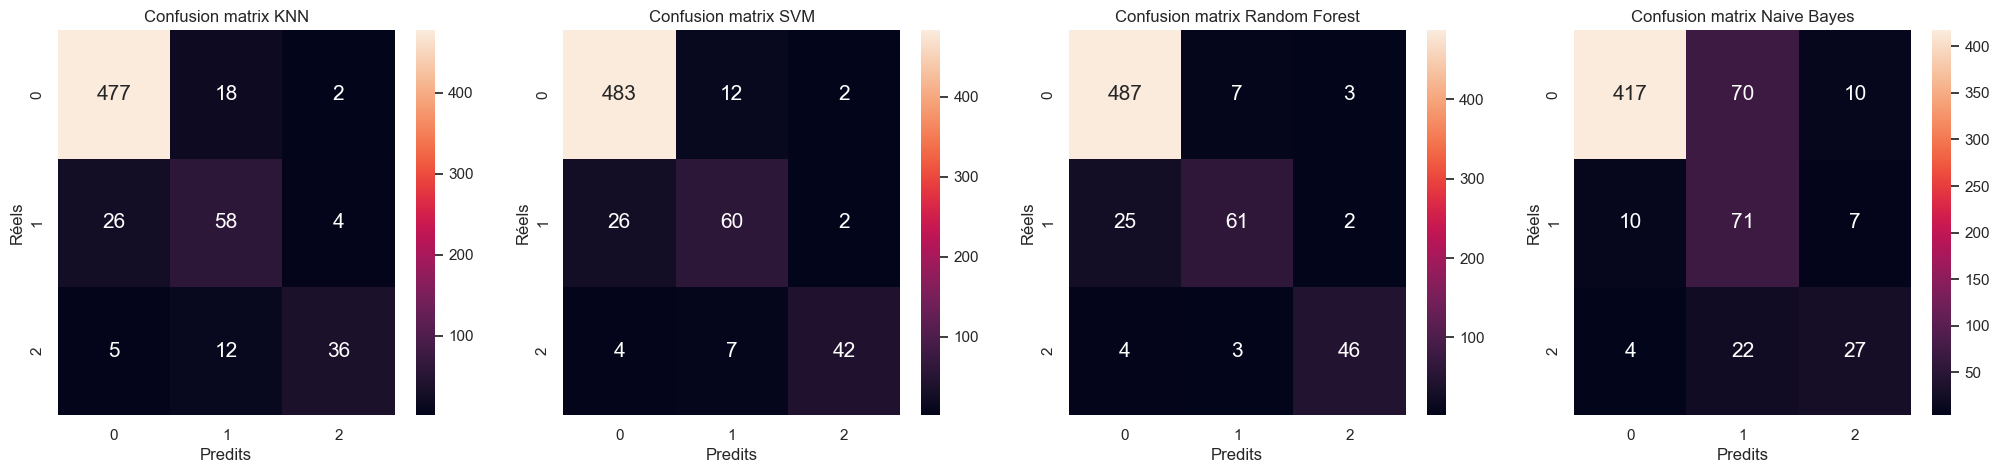

In [141]:
plt.figure(figsize=(25, 5))
models = [yknn, ysvm, yforest, ygaussian]
models_name = ["KNN", "SVM", "Random Forest", "Naive Bayes"]
i = 1
for model in models : 
    plt.subplot(1,4,i)
    sns.heatmap(metrics.confusion_matrix(labels_test, model), annot=True, annot_kws={"size": 15}, fmt='d')
    plt.title(f"Confusion matrix {models_name[i-1]}")
    plt.xlabel("Predits")
    plt.ylabel("Réels")
    i+=1
plt.show()

On peut meme afficher avec des pourcentage

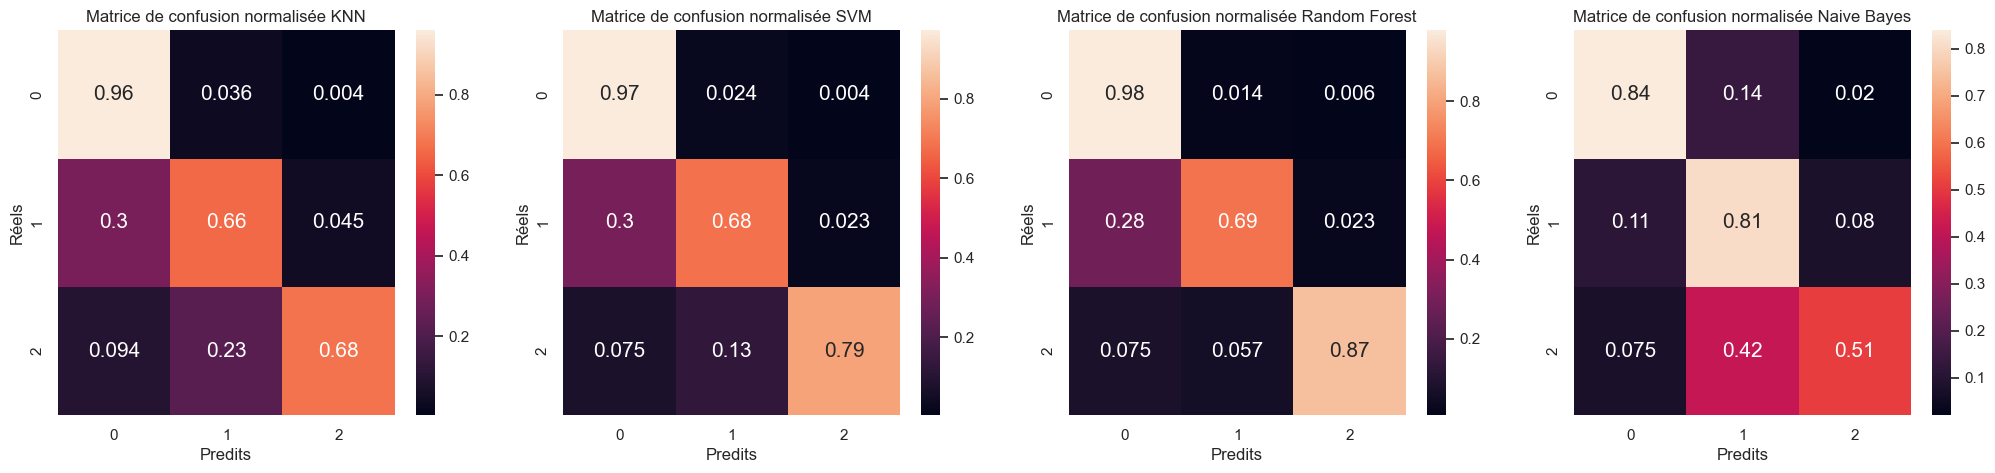

In [142]:
plt.figure(figsize=(25, 5))
i = 1
for model in models : 
    plt.subplot(1,4,i)
    sns.heatmap(metrics.confusion_matrix(labels_test, model, normalize='true'), annot=True, annot_kws={"size": 15})
    plt.title(f"Matrice de confusion normalisée {models_name[i-1]}")
    plt.xlabel("Predits")
    plt.ylabel("Réels")
    i+=1
plt.show()

On peut ainsi voir le problème qu'on a énoncé plus tôt, la classe 0 étant majoritaire arrive à être extrêmement bien classifiée, par contre la classe 1 et 2 bien moins n'arrivant qu'à peine 0.79 au plus. 

Le Random Forest étant donné qu'il a, en interne, un module de sélection des caractéristiques il atteint un bien meilleur résultat sur la classe minoritaire.

#### Bonus

Comment afficher les courbes ROC Auc pour une classification multi classes

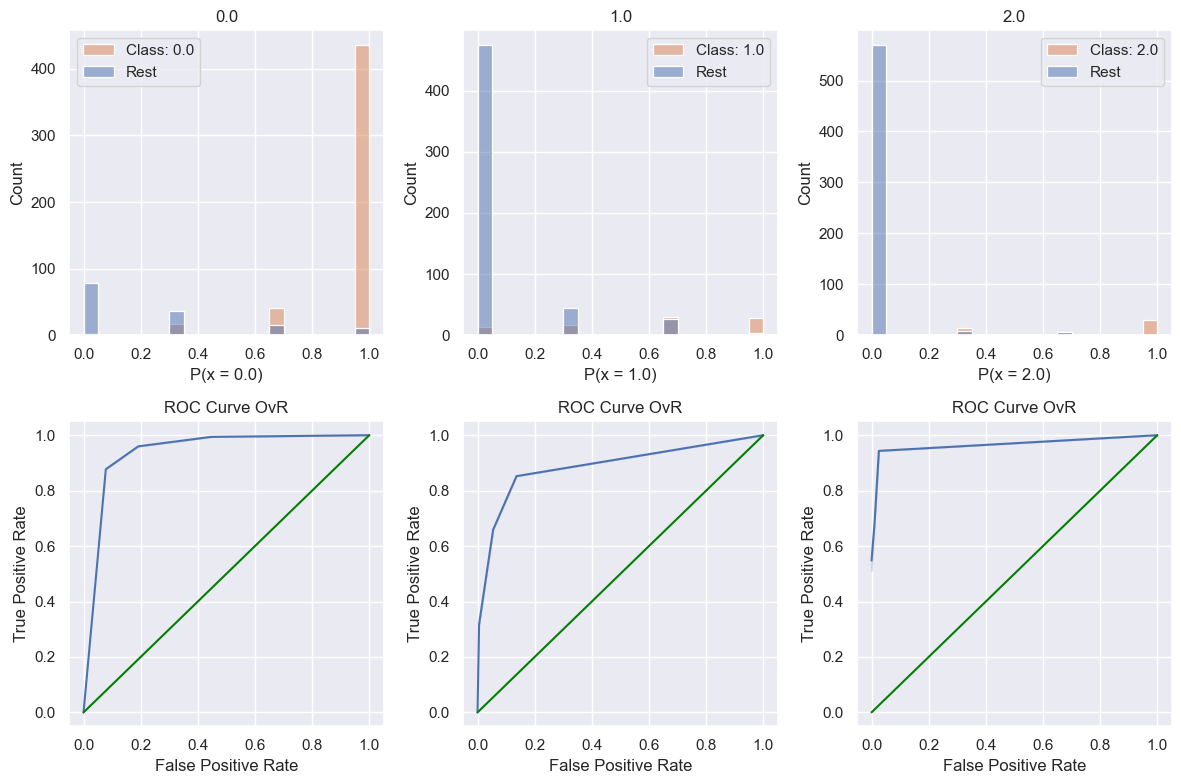

In [108]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = metrics.confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = knn.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = fetal_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in labels_test]
    df_aux['prob'] = knn.predict_proba(fetal_test)[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = metrics.roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

## Features selection

On a obtenu déjà d'excellents résultats, maintenant on va voir si on peut aller encore plus loin en sélectionnant les features où en en créant de nouvelles. Pour se faire on va tenter plusieurs approches : 

### PCA

In [12]:
number_comp = 17
columns_pca = [f'PC{i + 1}' for i in range(number_comp)]
pca = PCA(n_components=number_comp)
fetal_train_pca = pd.DataFrame(pca.fit_transform(fetal_train), columns=columns_pca)
fetal_test_pca = pd.DataFrame(pca.transform(fetal_test), columns=columns_pca)
print(f"La variance exprimée totale est de : {sum(pca.explained_variance_ratio_)*100}%")

La variance exprimée totale est de : 99.05308632043284%


On voit là qu'on peut ainsi garder 99% de la variance globale avec 4 variables de moins, on va maintenant restandardiser et remettre les modèles et évaluer

In [13]:
scaler = StandardScaler()

fetal_train_pca = pd.DataFrame(scaler.fit_transform(fetal_train_pca), columns=columns_pca)
fetal_test_pca = pd.DataFrame(scaler.transform(fetal_test_pca), columns=columns_pca)

#### Entrainement des modèles

In [14]:
# la mesure de distance est mise par défaut et c'est donc une distance Euclidienne
knn_parameters = {'n_neighbors':np.arange(1,20,2), 'p' : np.arange(1,4,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_pca,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(fetal_train_pca,labels_train)

Les meilleurs paramètres sont : {'n_neighbors': 1, 'p': 2}


KNeighborsClassifier(n_neighbors=1)

In [15]:
svm_parameters = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ["poly", "rbf", "sigmoid"], 'degree' : np.arange(2, 10), 'gamma' : ['scale', 'auto'], 'decision_function_shape' : ['ovo', 'ovr']}
svm = SVC()
clf = GridSearchCV(svm, svm_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_pca,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

svm=SVC(**clf.best_params_, probability=True) # pour pouvoir calculer le ROC AUC Score
svm.fit(fetal_train_pca,labels_train)

Les meilleurs paramètres sont : {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=10, decision_function_shape='ovo', degree=2, probability=True)

In [17]:
forest_parameters = {'n_estimators' : np.arange(50, 251, 10), 'criterion' : ['gini', 'entropy', 'log_loss'], 'max_features' : ['sqrt', 'log2']}
forest = RandomForestClassifier()
clf = GridSearchCV(forest, forest_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_pca,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

forest=RandomForestClassifier(**clf.best_params_)
forest.fit(fetal_train_pca,labels_train)

Les meilleurs paramètres sont : {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 70}


RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=70)

In [19]:
gaussian = GaussianNB()
gaussian.fit(fetal_train_pca,labels_train)

GaussianNB()

#### Evaluation

In [20]:
yknn = knn.predict(fetal_test_pca)
ysvm = svm.predict(fetal_test_pca)
yforest = forest.predict(fetal_test_pca)
ygaussian = gaussian.predict(fetal_test_pca)

In [21]:
print("F1-score")
print("="*15)
print(f"KNN : {metrics.f1_score(labels_test, yknn, average='macro')*100:.2f}%")
print(f"SVM : {metrics.f1_score(labels_test, ysvm, average='macro')*100:.2f}%")
print(f"Random Forest : {metrics.f1_score(labels_test, yforest, average='macro')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.f1_score(labels_test, ygaussian, average='macro')*100:.2f}%")

print("\nAUC-score")
print("="*15)
print(f"KNN : {metrics.roc_auc_score(labels_test, knn.predict_proba(fetal_test_pca), average='macro', multi_class='ovr')*100:.2f}%")
print(f"SVM : {metrics.roc_auc_score(labels_test, svm.predict_proba(fetal_test_pca), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Random Forest : {metrics.roc_auc_score(labels_test, forest.predict_proba(fetal_test_pca), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.roc_auc_score(labels_test, gaussian.predict_proba(fetal_test_pca), average='macro', multi_class='ovr')*100:.2f}%")

F1-score
KNN : 79.14%
SVM : 85.45%
Random Forest : 83.23%
Gaussian Naive Bayes : 67.27%

AUC-score
KNN : 82.97%
SVM : 97.72%
Random Forest : 97.42%
Gaussian Naive Bayes : 90.04%


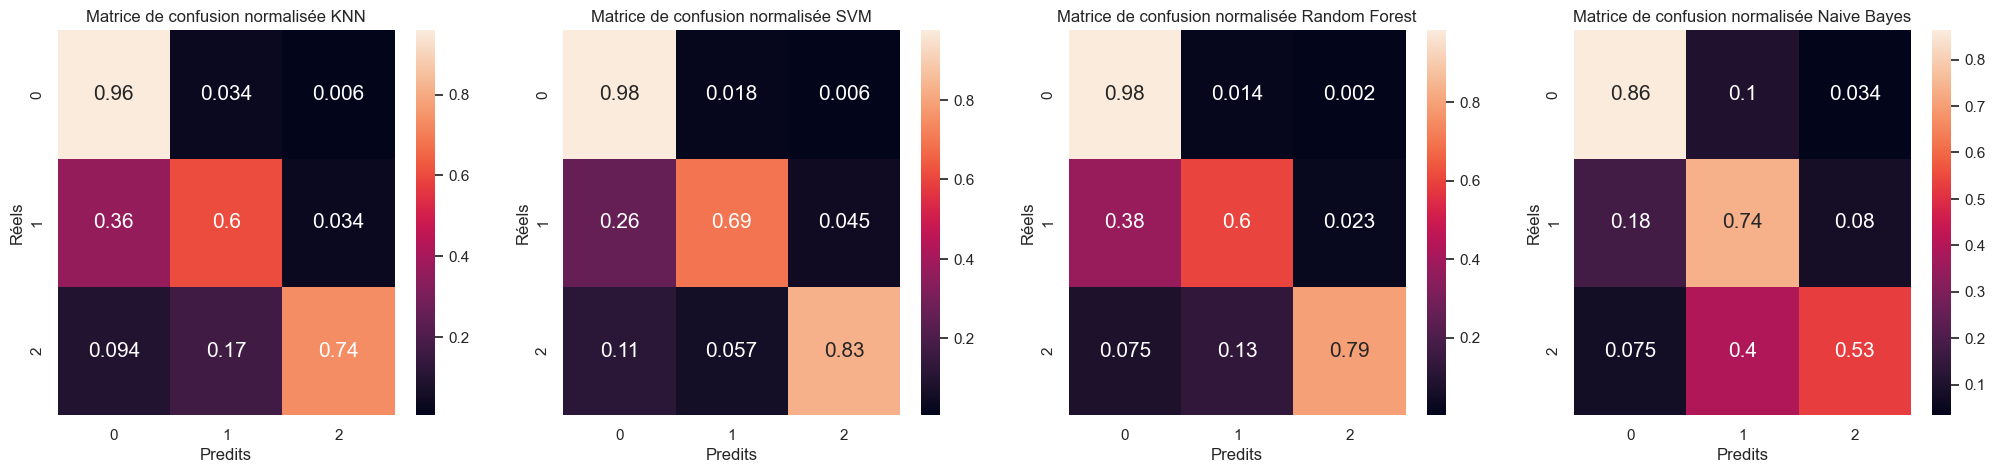

In [23]:
plt.figure(figsize=(25, 5))
models = [yknn, ysvm, yforest, ygaussian]
models_name = ["KNN", "SVM", "Random Forest", "Naive Bayes"]
i = 1
for model in models : 
    plt.subplot(1,4,i)
    sns.heatmap(metrics.confusion_matrix(labels_test, model, normalize='true'), annot=True, annot_kws={"size": 15})
    plt.title(f"Matrice de confusion normalisée {models_name[i-1]}")
    plt.xlabel("Predits")
    plt.ylabel("Réels")
    i+=1
plt.show()

Et si on prenait encore moins de variables pour voir ?

In [25]:
number_comp = 14
columns_pca = [f'PC{i + 1}' for i in range(number_comp)]
pca = PCA(n_components=number_comp)
fetal_train_pca_2 = pd.DataFrame(pca.fit_transform(fetal_train), columns=columns_pca)
fetal_test_pca_2 = pd.DataFrame(pca.transform(fetal_test), columns=columns_pca)
print(f"La variance exprimée totale est de : {sum(pca.explained_variance_ratio_)*100}%")

La variance exprimée totale est de : 96.27286462903284%


In [26]:
scaler = StandardScaler()

fetal_train_pca_2 = pd.DataFrame(scaler.fit_transform(fetal_train_pca_2), columns=columns_pca)
fetal_test_pca_2 = pd.DataFrame(scaler.transform(fetal_test_pca_2), columns=columns_pca)

In [28]:
# la mesure de distance est mise par défaut et c'est donc une distance Euclidienne
knn_parameters = {'n_neighbors':np.arange(1,20,2), 'p' : np.arange(1,4,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_pca_2,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(fetal_train_pca_2,labels_train)

Les meilleurs paramètres sont : {'n_neighbors': 3, 'p': 2}


KNeighborsClassifier(n_neighbors=3)

In [29]:
svm_parameters = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ["poly", "rbf", "sigmoid"], 'degree' : np.arange(2, 10), 'gamma' : ['scale', 'auto'], 'decision_function_shape' : ['ovo', 'ovr']}
svm = SVC()
clf = GridSearchCV(svm, svm_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_pca_2,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

svm=SVC(**clf.best_params_, probability=True) # pour pouvoir calculer le ROC AUC Score
svm.fit(fetal_train_pca_2,labels_train)

Les meilleurs paramètres sont : {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=10, decision_function_shape='ovo', degree=2, probability=True)

In [30]:
forest_parameters = {'n_estimators' : np.arange(50, 251, 10), 'criterion' : ['gini', 'entropy', 'log_loss'], 'max_features' : ['sqrt', 'log2']}
forest = RandomForestClassifier()
clf = GridSearchCV(forest, forest_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_pca_2,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

forest=RandomForestClassifier(**clf.best_params_)
forest.fit(fetal_train_pca_2,labels_train)

Les meilleurs paramètres sont : {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 120}


RandomForestClassifier(criterion='log_loss', n_estimators=120)

In [31]:
gaussian = GaussianNB()
gaussian.fit(fetal_train_pca_2,labels_train)

GaussianNB()

In [32]:
yknn = knn.predict(fetal_test_pca_2)
ysvm = svm.predict(fetal_test_pca_2)
yforest = forest.predict(fetal_test_pca_2)
ygaussian = gaussian.predict(fetal_test_pca_2)

print("F1-score")
print("="*15)
print(f"KNN : {metrics.f1_score(labels_test, yknn, average='macro')*100:.2f}%")
print(f"SVM : {metrics.f1_score(labels_test, ysvm, average='macro')*100:.2f}%")
print(f"Random Forest : {metrics.f1_score(labels_test, yforest, average='macro')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.f1_score(labels_test, ygaussian, average='macro')*100:.2f}%")

print("\nAUC-score")
print("="*15)
print(f"KNN : {metrics.roc_auc_score(labels_test, knn.predict_proba(fetal_test_pca_2), average='macro', multi_class='ovr')*100:.2f}%")
print(f"SVM : {metrics.roc_auc_score(labels_test, svm.predict_proba(fetal_test_pca_2), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Random Forest : {metrics.roc_auc_score(labels_test, forest.predict_proba(fetal_test_pca_2), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.roc_auc_score(labels_test, gaussian.predict_proba(fetal_test_pca_2), average='macro', multi_class='ovr')*100:.2f}%")

F1-score
KNN : 78.82%
SVM : 84.39%
Random Forest : 81.89%
Gaussian Naive Bayes : 66.81%

AUC-score
KNN : 89.73%
SVM : 97.12%
Random Forest : 97.26%
Gaussian Naive Bayes : 90.56%


On peut ainsi voir que le choix de garder 17 variables est meilleur que 14 variables en terme de performances atteintes. Maintenant abordant une autre approche de sélection de caractéristiques

### Features selection

On va procéder à une sélection des meilleures caractéristiques se basant sur un test statistique, dans ce cas là, le chi2. Je vous laisse le soin de chercher autour de ces tests statistiques c'est intéressant de voir les différents tests comment ils marchent. 

Ce test requiert un contenu purement positif et par conséquent on change le scaler pour prendre le MinMaxScaler

In [2]:
fetal_data = pd.read_csv("fetal_health.csv")

fetal_features = fetal_data.copy()
labels = fetal_features.fetal_health
fetal_features.drop(columns="fetal_health", axis=1, inplace=True)

labels -= 1 # originally, the targets are 1-3; we will use 0-2

fetal_train, fetal_test, labels_train, labels_test = train_test_split(fetal_features, labels, test_size=0.3, random_state=42, stratify=labels)

fetal_train.shape, fetal_test.shape

((1488, 21), (638, 21))

In [4]:
scaler = MinMaxScaler()
features = fetal_train.columns
fetal_train = pd.DataFrame(scaler.fit_transform(fetal_train), columns=features)
fetal_test = pd.DataFrame(scaler.transform(fetal_test), columns=features)
fetal_train.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,1488.0,0.500921,0.180757,0.0,0.370370,0.500000,0.629630,1.0
accelerations,1488.0,0.178726,0.215772,0.0,0.000000,0.111111,0.333333,1.0
fetal_movement,1488.0,0.021593,0.103706,0.0,0.000000,0.000000,0.006289,1.0
uterine_contractions,1488.0,0.310820,0.208410,0.0,0.142857,0.285714,0.428571,1.0
light_decelerations,1488.0,0.122088,0.194435,0.0,0.000000,0.000000,0.200000,1.0
severe_decelerations,1488.0,0.002688,0.051795,0.0,0.000000,0.000000,0.000000,1.0
prolongued_decelerations,1488.0,0.031989,0.117578,0.0,0.000000,0.000000,0.000000,1.0
abnormal_short_term_variability,1488.0,0.471148,0.233137,0.0,0.270270,0.486486,0.662162,1.0
mean_value_of_short_term_variability,1488.0,0.167487,0.130930,0.0,0.073529,0.147059,0.220588,1.0
percentage_of_time_with_abnormal_long_term_variability,1488.0,0.108059,0.203177,0.0,0.000000,0.000000,0.120879,1.0


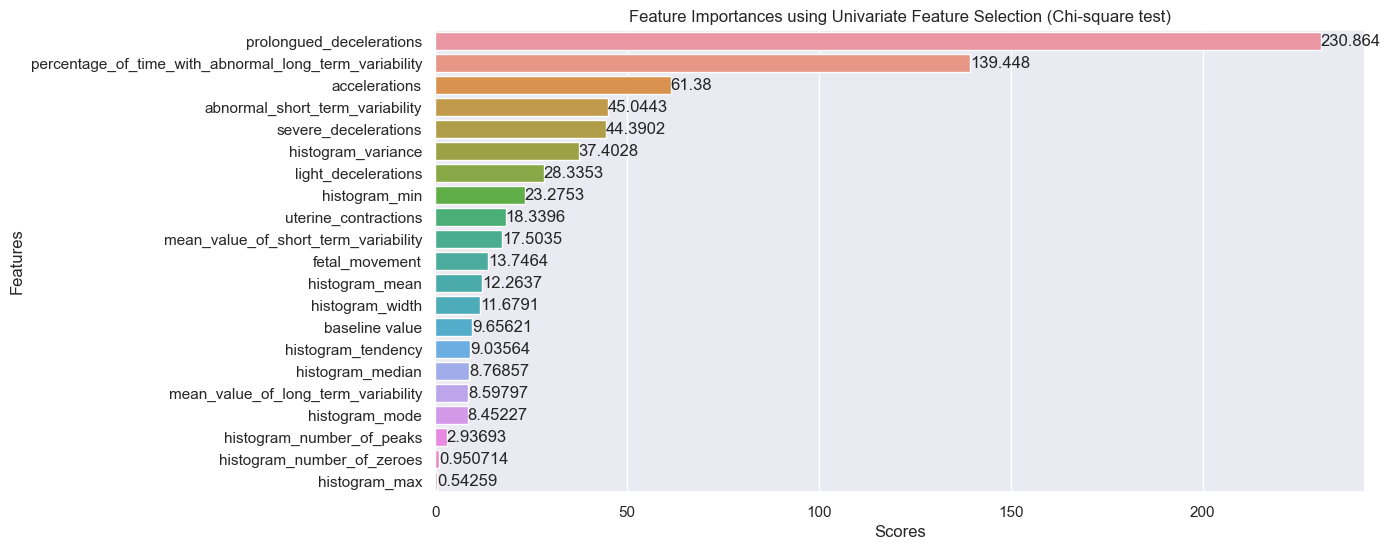

In [5]:
# apply univariate feature selection
best_features = SelectKBest(score_func=chi2, k=5).fit(fetal_train, labels_train)

# get the scores and selected features
scores = best_features.scores_
selected_features = fetal_train.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(fetal_train.columns)[sorted_idxs]

# plot scores
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sorted_scores, y=sorted_feature_names)
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (Chi-square test)')
plt.show()

On peut ainsi voir l'importance de chaque caractéristiques par rapport à la classe d'arrivée, on observe clairement que y a certaines caractéristiques extrêmement importante. On peut effectuer le test avec d'autres test statistiques, par exemple ANOVA

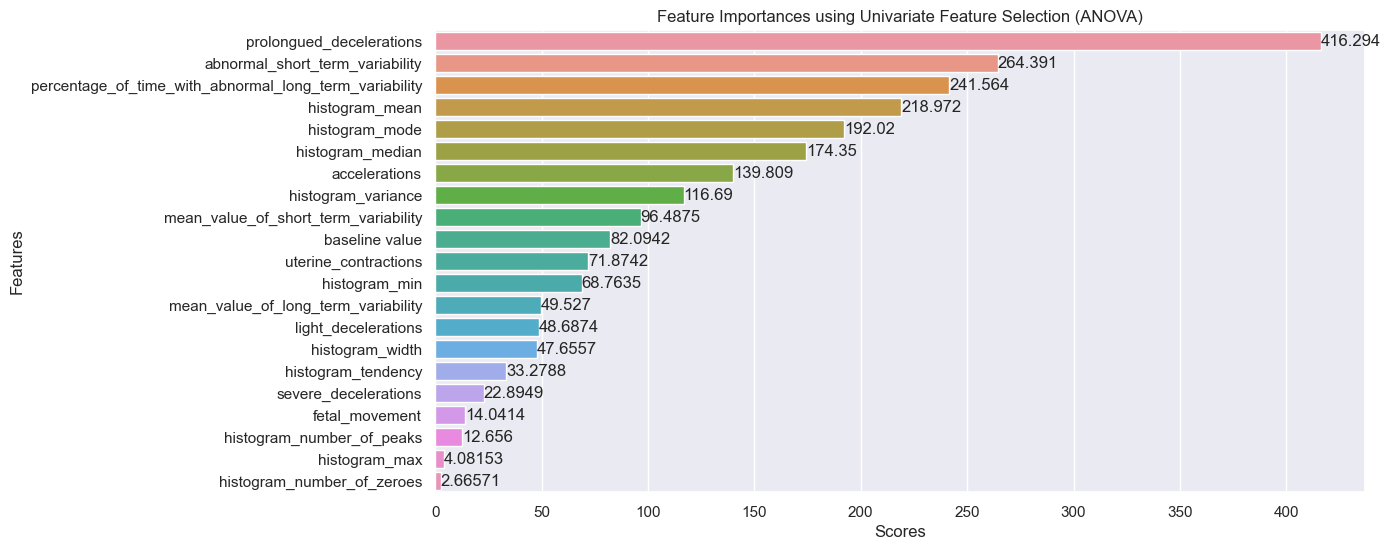

In [6]:
# apply univariate feature selection
best_features = SelectKBest(score_func=f_classif, k=5).fit(fetal_train, labels_train)

# get the scores and selected features
scores = best_features.scores_
selected_features = fetal_train.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(fetal_train.columns)[sorted_idxs]

# plot scores
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sorted_scores, y=sorted_feature_names)
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (ANOVA)')
plt.show()

Dans la suite on va utiliser le resultat obtenu avec le chi2, on va garder que les variables ayant un score dépassant 20 et voir les performances de classification avec

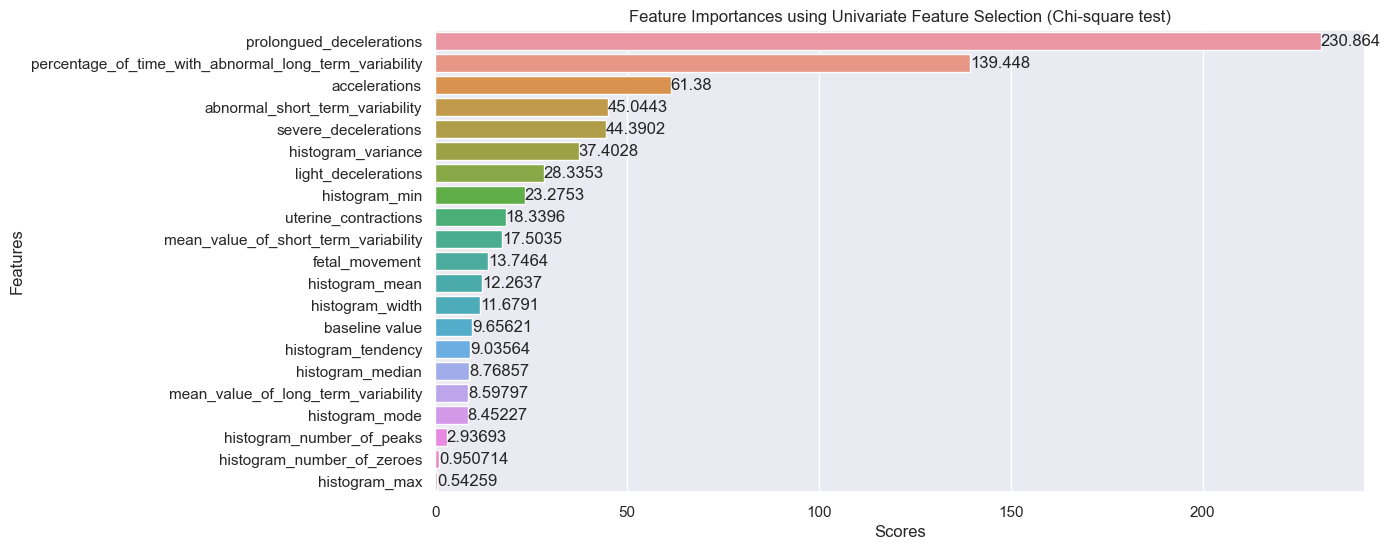

In [7]:
# apply univariate feature selection
best_features = SelectKBest(score_func=chi2, k=5).fit(fetal_train, labels_train)

# get the scores and selected features
scores = best_features.scores_
selected_features = fetal_train.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(fetal_train.columns)[sorted_idxs]

# plot scores
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sorted_scores, y=sorted_feature_names)
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (Chi-square test)')
plt.show()

In [8]:
columns_selected = sorted_feature_names[sorted_scores > 20] # masque
fetal_train_chi = fetal_train.copy()
fetal_train_chi = fetal_train_chi.loc[:, columns_selected]

fetal_test_chi = fetal_test.copy()
fetal_test_chi = fetal_test_chi.loc[:, columns_selected]

#### Entrainement des modèles

In [9]:
# KNN
knn_parameters = {'n_neighbors':np.arange(1,20,2), 'p' : np.arange(1,4,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_chi,labels_train)
print(f"Les meilleurs paramètres pour le KNN sont : {clf.best_params_}")

knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(fetal_train_chi,labels_train)

# SVM
# svm_parameters = {'C' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ["poly", "rbf", "sigmoid"], 'degree' : np.arange(2, 10), 'gamma' : ['scale', 'auto'], 'decision_function_shape' : ['ovo', 'ovr']}
# svm = SVC()
# clf = GridSearchCV(svm, svm_parameters, scoring='accuracy', cv=5)
# clf.fit(fetal_train_chi,labels_train)
# print(f"Les meilleurs paramètres pour le SVM sont : {clf.best_params_}")

# svm=SVC(**clf.best_params_, probability=True) # pour pouvoir calculer le ROC AUC Score
# svm.fit(fetal_train_chi,labels_train)

# Random Forest
forest_parameters = {'n_estimators' : np.arange(50, 251, 10), 'criterion' : ['gini', 'entropy', 'log_loss'], 'max_features' : ['sqrt', 'log2']}
forest = RandomForestClassifier()
clf = GridSearchCV(forest, forest_parameters, scoring='accuracy', cv=5)
clf.fit(fetal_train_chi,labels_train)
print(f"Les meilleurs paramètres pour le Random Forest sont : {clf.best_params_}")

forest=RandomForestClassifier(**clf.best_params_)
forest.fit(fetal_train_chi,labels_train)

# Naive Bayes
gaussian = GaussianNB()
gaussian.fit(fetal_train_chi,labels_train)

Les meilleurs paramètres pour le KNN sont : {'n_neighbors': 1, 'p': 1}
Les meilleurs paramètres pour le Random Forest sont : {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 140}


GaussianNB()

#### Evaluation

In [11]:
yknn = knn.predict(fetal_test_chi)
#ysvm = svm.predict(fetal_test_chi)
yforest = forest.predict(fetal_test_chi)
ygaussian = gaussian.predict(fetal_test_chi)

print("F1-score")
print("="*15)
print(f"KNN : {metrics.f1_score(labels_test, yknn, average='macro')*100:.2f}%")
#print(f"SVM : {metrics.f1_score(labels_test, ysvm, average='macro')*100:.2f}%")
print(f"Random Forest : {metrics.f1_score(labels_test, yforest, average='macro')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.f1_score(labels_test, ygaussian, average='macro')*100:.2f}%")

print("\nAUC-score")
print("="*15)
print(f"KNN : {metrics.roc_auc_score(labels_test, knn.predict_proba(fetal_test_chi), average='macro', multi_class='ovr')*100:.2f}%")
#print(f"SVM : {metrics.roc_auc_score(labels_test, svm.predict_proba(fetal_test_chi), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Random Forest : {metrics.roc_auc_score(labels_test, forest.predict_proba(fetal_test_chi), average='macro', multi_class='ovr')*100:.2f}%")
print(f"Gaussian Naive Bayes : {metrics.roc_auc_score(labels_test, gaussian.predict_proba(fetal_test_chi), average='macro', multi_class='ovr')*100:.2f}%")

F1-score
KNN : 82.18%
Random Forest : 85.08%
Gaussian Naive Bayes : 64.75%

AUC-score
KNN : 86.21%
Random Forest : 97.49%
Gaussian Naive Bayes : 89.55%


On a pu améliorer les performances du KNN et préserver quasiment les mêmes performances pour le Random Forest avec presque 3 fois moins de variables

## Pour Aller plus loin

Bien sur ce notebook avait pour but de présenter un workflow et non pas chercher forcément le meilleur résultat obtenable, pour se faire on pouvait imaginer d'autres approches (d'autres modèles, d'autres stratégies...) et un travail plus en profondeur, pour se faire je vous conseille l'étude de ce notebook traitant de cette problématique et qui pourra énormément vous servir au futur : [lien](https://www.kaggle.com/code/yuvalaltman/fetal-health-classification)

Alors pour synthétiser qu'est ce qui serait intéressant de voir : 
- D'autres approches de features engineering (recursive se basant sur Random Forest par exemple)
- Etudier la faisabilité de l'augmentation de données pour rééquilibrer la classification et tenter quelques techniques
- Mettre en place un classifieur utilisant ensemble learning : mélangeant pourquoi pas 4 classifieurs présentés ici
- Utilisation d'un réseau de neurones artificiel ANN
- Utilisation d'autres modèles de Machine Learning basé sur le boosting : XGBoost, LGMBoost, CatBoost etc.